# Open-Vocabulary Attention Maps (OVAM) - Img2Img

Colab demo of **Open-Vocabulary Attention Maps with Token Optimization for Semantic Segmentation in Diffusion Models**.

[![GitHub](https://img.shields.io/badge/GitHub-vpulab/ovam-blue.svg)](https://github.com/vpulab/ovam/)
[![arXiv](https://img.shields.io/badge/arXiv-2403.14291-b31b1b.svg)](https://arxiv.org/abs/2403.14291)

Short example on how to use with Img2Img pipeline


Install ovam from GitHub. Can take a while (~3 mins)

In [1]:
!pip install git+https://github.com/vpulab/ovam.git -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 88.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 57.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.5 MB/s eta 0:00:00

Import packages

In [6]:
import torch
from diffusers import StableDiffusionImg2ImgPipeline
from ovam import StableDiffusionHooker
from ovam.utils import set_seed
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from PIL import Image
import gc

Initialize Stable Diffusion V1.5

In [3]:
device = "cuda"
model_id_or_path = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id_or_path, torch_dtype=torch.float16)
pipe = pipe.to(device)

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Init image (from Stable Diffusion Image)

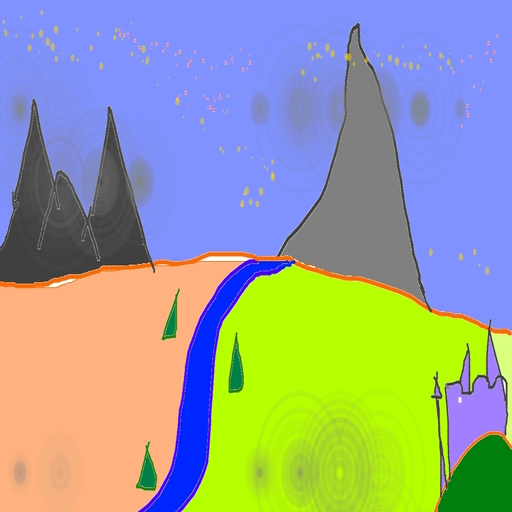

In [4]:
url = "https://raw.githubusercontent.com/CompVis/stable-diffusion/main/assets/stable-samples/img2img/sketch-mountains-input.jpg"

response = requests.get(url)
init_image = Image.open(BytesIO(response.content)).convert("RGB")
init_image = init_image.resize((512, 512))

init_image

Generate image guided by text and initial image. Store attentions with Ovam hooker

  0%|          | 0/37 [00:00<?, ?it/s]

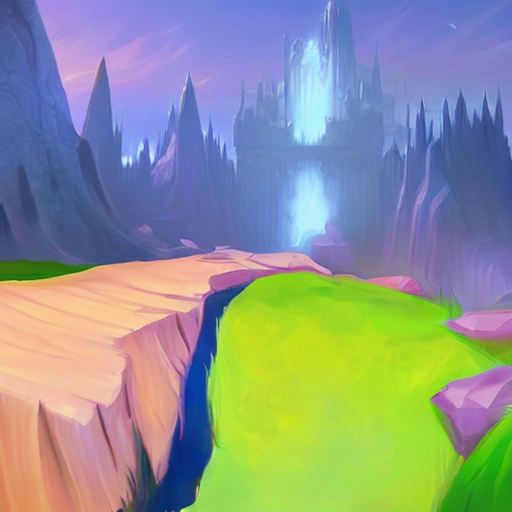

In [5]:

prompt = "A fantasy landscape, trending on artstation"

# Generate image storing the internal attentions
set_seed(1)
with StableDiffusionHooker(pipe) as hooker:
  image = pipe(prompt=prompt, image=init_image, strength=0.75, guidance_scale=7.5).images[0]

image

Generate attentions for the prompt "A castle".

The resulting attentions will have shape \[batch dimension=1, number of tokens=5, width=512, height=512\], with attentions for the tokens 1=`<SoT>`, 2="A", 3="castle", 4=`<EoT>`.

In [7]:
# Evaluator of attention
ovam_evaluator = hooker.get_ovam_callable(expand_size=(512, 512))

attribution_prompt = "A castle"

with torch.no_grad():
    attention_maps = ovam_evaluator(attribution_prompt)
    attention_maps = attention_maps[0].cpu().numpy() # (4, 512, 512) <SoT>A castle<EoT>

Plot results

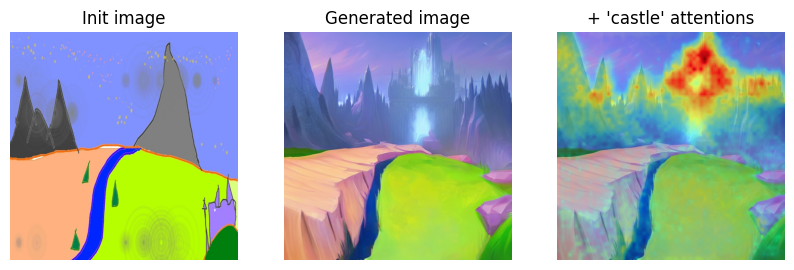

In [8]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 4))

ax0.imshow(init_image)
ax1.imshow(image)
ax2.imshow(image)

# Normalize attentions [0, 1] to use as alpha in plot
castle_attention = attention_maps[2] # Castle is the third word <SoT> a castle<EoT>
castle_attention = (castle_attention - castle_attention.min())
castle_attention = castle_attention / castle_attention.max()

ax2.imshow(castle_attention, alpha=castle_attention.astype(float), cmap='jet')

ax0.set_title("Init image")
ax0.axis('off')

ax1.set_title("Generated image")
ax1.axis('off')

ax2.set_title("+ 'castle' attentions")
ax2.axis('off')

fig.savefig("example_img2img.jpg", bbox_inches="tight")

Free memory

In [ ]:
del ovam_evaluator
del hooker
torch.cuda.empty_cache()
gc.collect()